In [4]:
# Required to setup DB and consume GTFS static data
import mysql.connector
from mysql.connector import Error
from mysql.connector import errorcode
from mysql.connector.constants import ClientFlag
import os
import csv
from datetime import datetime
from time import time, sleep

STATIC_CSV = "static_.csv"
DB_CSV = "db_.csv"
RETRIEVAL_FREQ = 30
RETRIEVAL_TIME = 360

In [2]:
def executeScriptsFromFile(filename, cursor):
    # Open and read the file as a single buffer
    fd = open(filename, 'r')
    sqlFile = fd.read()
    fd.close()

    # all SQL commands (split on ';')
    sqlCommands = sqlFile.split(';')

    # Execute every command from the input file
    for command in sqlCommands:
        # This will skip and report errors
        # For example, if the tables do not yet exist, this will skip over
        # the DROP TABLE commands
        try:
            cursor.execute(command)
        except mysql.connector.Error as error:
            print("Error occurred while executing script : ", error)

In [3]:
## Create Tables and Indexes

def db_setup(filepath, tab=True, idx=False):
    connection = mysql.connector.connect(host='localhost', user='root', password='admin')
    try:
        cursor = connection.cursor()
        print("FILEPATH received : ", filepath)
        createtab_file = filepath + "create-tables.sql"
        createidx_file = filepath + "create-index.sql"
        
        if(tab):
            executeScriptsFromFile(createtab_file, cursor)
            print("TABLES CREATED ...")
            connection.commit()
        
        if(idx):
            executeScriptsFromFile(createidx_file, cursor)
            print("INDEXES CREATED ...")
            connection.commit()
    
    except mysql.connector.Error as error:
        connection.rollback() #rollback if any exception occured
        print("The following error has occurred ... ".format(error))

    finally:
        #closing database connection.
        if(connection.is_connected()):
            cursor.close()
            connection.close()
            print("DB Setup complete. MySQL connection is closed.")

In [4]:
def all_tables(path, folder, date):
    filepath = "\'" + path + folder + "/"
    
    # Agency
    filename = "agency.txt'"
    tablename = "gtfs.agency"
    print(filepath)
    print(filename)
    print(tablename)
    bulk_ins(filepath, filename, tablename)
    
    # Calendar_Dates
    filename = "calendar_dates.txt'"
    tablename = "gtfs.calendar_dates"
    bulk_ins(filepath, filename, tablename)
    
    # Routes
    filename = "routes.txt'"
    tablename = "gtfs.routes"
    bulk_ins(filepath, filename, tablename)
    
    # Shapes
    filename = "shapes.txt'"
    tablename = "gtfs.shapes"
    bulk_ins(filepath, filename, tablename)
    
    # Stop_Times
    filename = "stop_times.txt'"
    tablename = "gtfs.stop_times"
    bulk_ins(filepath, filename, tablename)
    
    #Stops
    filename = "stops.txt'"
    tablename = "gtfs.stops"
    bulk_ins(filepath, filename, tablename)
    
    #Transfers
    filename = "transfers.txt'"
    tablename = "gtfs.transfers"
    bulk_ins(filepath, filename, tablename)
    
    #Trips
    filename = "trips.txt'"
    tablename = "gtfs.trips"
    bulk_ins(filepath, filename, tablename, date)

In [5]:
def bulk_ins(filepath, filename, tablename, date=None):
    try:
        connection = mysql.connector.connect(host='localhost', database='gtfs', user='root', \
                                             password='admin', client_flags=[ClientFlag.LOCAL_FILES])
        print("Connected to DB ...", ClientFlag.LOCAL_FILES)
        
        # Create cursor and execute Load SQL
        autoc_sql = "SET autocommit=0;"
        ucheck_sql = "SET unique_checks=0;"
        fcheck_sql = "set foreign_key_checks=0;"
        logcheck_sql = "set sql_log_bin=0;"
        
        load_sql = ("LOAD DATA LOCAL INFILE " + filepath + filename +
                    " INTO TABLE " + tablename +
                    " FIELDS TERMINATED BY ','"
                    " OPTIONALLY ENCLOSED BY '\"'"
                    " LINES TERMINATED BY '\\n'"
                    " IGNORE 1 LINES")
        
        # INSERT DATE IN TABLES STOP_TIMES AND TRIPS
#         if(tablename == "gtfs.stop_times" or tablename == "gtfs.trips"):
        if(tablename == "gtfs.trips"):
            print("DATE VALUE RECEIVED ... ", date)
            load_sql = load_sql + " SET trip_date = '" + str(date) + "';"
        else:
            load_sql = load_sql + ";"
        
        cursor = connection.cursor()
        print("BULK INS ... ")
        print("FILEPATH received : ", filepath.strip('\''))
        print(filepath + filename)
        print(load_sql)
        
        cursor.execute(autoc_sql)
        cursor.execute(ucheck_sql)
        cursor.execute(fcheck_sql)
        cursor.execute(logcheck_sql)
        
        cursor.execute(load_sql)
        connection.commit()
        print("Succuessfully loaded the table " + tablename + " from " + filename.strip('\'') + " ... ")
    
    except mysql.connector.Error as error :
        print(cursor.statement)
        connection.rollback() #rollback if any exception occured
        print("Failed inserting record into table " + tablename + " from " + filename.strip('\'') + " ... {}".format(error))
        
    finally:
        #closing database connection.
        if(connection.is_connected()):
            cursor.close()
            connection.close()
            print("MySQL connection is closed")

In [6]:
def main():

    # FETCH FILES
    # READS TWO CSV FILES FROM THE CURRENT WORKING DIRECTORY
    # DB_CSV PROVIDES THE PATH WHERE THE TABLE AND INDEX CREATION SCRIPTS ARE KEPT
    # STATIC_CSV PROVIDES THE PATH WHERE THE UNZIPPED STATIC DATA IS KEPT
    cwd = os.getcwd()
    db_csv = cwd.replace("\\", "/") + "/" + DB_CSV
    static_csv = cwd.replace("\\", "/") + "/" + STATIC_CSV
    
    # GET DB SCRIPTS PATH
    db_scripts = ""
    with open(db_csv, "r") as file:
        next(file)
        for row in file:
            db_scripts = row.strip().replace("\\", "/") + "/"
    
#     # SETUP DB
#     db_setup(db_scripts, tab=True, idx=False)
    
#     # DUMP DATA TO DB
#     dataset_path = ""
#     folder_name = ""
#     folder_date = ""
#     with open(static_csv, "r") as file:
#         next(file)
#         for row in file:
#             row = row.strip().split(",")
#             dataset_path = row[0].replace("\\", "/") + "/"
#             folder_name = row[1]
#             folder_date = row[2]
#             all_tables(dataset_path, folder_name, folder_date)
    
if __name__ == "__main__":
    main()

FILEPATH received :  C:/Users/kakka/Documents/GTFS_/code/
TABLES CREATED ...
DB Setup complete. MySQL connection is closed.
'C:/Users/kakka/Documents/GTFS_/static_data/NL-20190110.gtfs/
agency.txt'
gtfs.agency
Connected to DB ... 128
BULK INS ... 
FILEPATH received :  C:/Users/kakka/Documents/GTFS_/static_data/NL-20190110.gtfs/
'C:/Users/kakka/Documents/GTFS_/static_data/NL-20190110.gtfs/agency.txt'
LOAD DATA LOCAL INFILE 'C:/Users/kakka/Documents/GTFS_/static_data/NL-20190110.gtfs/agency.txt' INTO TABLE gtfs.agency FIELDS TERMINATED BY ',' OPTIONALLY ENCLOSED BY '"' LINES TERMINATED BY '\n' IGNORE 1 LINES;
Succuessfully loaded the table gtfs.agency from agency.txt ... 
MySQL connection is closed
Connected to DB ... 128
BULK INS ... 
FILEPATH received :  C:/Users/kakka/Documents/GTFS_/static_data/NL-20190110.gtfs/
'C:/Users/kakka/Documents/GTFS_/static_data/NL-20190110.gtfs/calendar_dates.txt'
LOAD DATA LOCAL INFILE 'C:/Users/kakka/Documents/GTFS_/static_data/NL-20190110.gtfs/calendar_

Succuessfully loaded the table gtfs.trips from trips.txt ... 
MySQL connection is closed


In [7]:
# Segregate Index Creation for the DB as it takes up a lot of time
# Run after all data has been inserted

# # FETCH FILES
# cwd = os.getcwd()
# db_csv = cwd.replace("\\", "/") + "/" + DB_CSV
# static_csv = cwd.replace("\\", "/") + "/" + STATIC_CSV

# # GET DB SCRIPTS PATH
# db_scripts = ""
# with open(db_csv, "r") as file:
#     next(file)
#     for row in file:
#         db_scripts = row.strip().replace("\\", "/") + "/"
# db_setup(db_scripts, tab=False, idx=True)

FILEPATH received :  C:/Users/kakka/Documents/GTFS_/code/
INDEXES CREATED ...
DB Setup complete. MySQL connection is closed.


In [6]:
# Generate a set of usable trip and service ids from the DB
def push_routes(filepath):
    try:
        connection = mysql.connector.connect(host='localhost', database='gtfs', user='root', \
                                             password='admin', client_flags=[ClientFlag.LOCAL_FILES])
        print("Connected to DB ...", ClientFlag.LOCAL_FILES)
        
        #
#         sel_sql = ( " SELECT DISTINCT ROUTE_SHORT_NAME, "
#                 " CASE ROUTE_TYPE "
#                 " WHEN '0' THEN 'TRAM'"
#                 " WHEN '1' THEN 'SUBWAY'"
#                 " WHEN '2' THEN 'RAIL'"
#                 " WHEN '3' THEN 'BUS'"
#                 " WHEN '4' THEN 'FERRY'"
#                 " END AS ROUTE_TYPE"
#                 " FROM GTFS.ROUTES ORDER BY ABS(ROUTE_SHORT_NAME), ROUTE_TYPE;" )
        
        sel_sql = ( " SELECT DISTINCT R.ROUTE_SHORT_NAME,"
                    " CASE R.ROUTE_TYPE "
                    " WHEN '0' THEN 'TRAM'"
                    " WHEN '1' THEN 'SUBWAY'"
                    " WHEN '2' THEN 'RAIL'"
                    " WHEN '3' THEN 'BUS'"
                    " WHEN '4' THEN 'FERRY'"
                    " END AS ROUTE_TYPE"
                    " FROM GTFS.ROUTES R, GTFS.TRIPS T"
                    " WHERE R.ROUTE_ID = T.ROUTE_ID"
                    " AND T.TRIP_ID IN ("
                    " SELECT DISTINCT ST.TRIP_ID"
                    " FROM GTFS.STOP_TIMES ST, GTFS.STOPS S"
                    " WHERE ST.STOP_ID = S.STOP_ID"
                    " AND UPPER(S.STOP_NAME) LIKE '%AMSTERDAM,%'"
                    " AND S.STOP_ID NOT LIKE '%stoparea%');" )
        
        cursor = connection.cursor()
        print("push_routes() ... ")
        print("FILEPATH received : ", filepath)
        print(sel_sql)
        cursor.execute(sel_sql)
        all_rows = cursor.fetchall()
        
        with open(filepath + 'routes_list.csv', 'w') as myfile:
            for row in all_rows:
                myfile.write(row[0] + "," + row[1] + "\n")
            print("Data write success ... ")
            print("Please check CSV file ROUTES.CSV at " + filepath)
            
#         with open(filepath + 'routes_list.csv', 'w') as myfile:
#             wr = csv.writer(myfile)
#             for row in all_rows:
#                 wr.writerow(row)
#             print("Data write success ... ")
#             print("Please check CSV file ROUTES.CSV at " + filepath)
    
    except mysql.connector.Error as error :
        print(cursor.statement)
        connection.rollback() #rollback if any exception occured
        print("Failed fetching data from GTFS.ROUTES ... {}".format(error))
        
    finally:
        #closing database connection.
        if(connection.is_connected()):
            cursor.close()
            connection.close()
            print("MySQL connection is closed")

In [28]:
# GENERATE ROUTE DETAILS FOR USER
# cwd = os.getcwd()
# print(cwd)
# push_routes(cwd.replace("\\", "/") + "/")

C:\Users\kakka\Documents\GTFS_\code
Connected to DB ... 128
push_routes() ... 
FILEPATH received :  C:/Users/kakka/Documents/GTFS_/code/
 SELECT DISTINCT R.ROUTE_SHORT_NAME, CASE R.ROUTE_TYPE  WHEN '0' THEN 'TRAM' WHEN '1' THEN 'SUBWAY' WHEN '2' THEN 'RAIL' WHEN '3' THEN 'BUS' WHEN '4' THEN 'FERRY' END AS ROUTE_TYPE FROM GTFS.ROUTES R, GTFS.TRIPS T WHERE R.ROUTE_ID = T.ROUTE_ID AND T.TRIP_ID IN ( SELECT DISTINCT ST.TRIP_ID FROM GTFS.STOP_TIMES ST, GTFS.STOPS S WHERE ST.STOP_ID = S.STOP_ID AND UPPER(S.STOP_NAME) LIKE '%AMSTERDAM,%' AND S.STOP_ID NOT LIKE '%stoparea%');
Data write success ... 
Please check CSV file ROUTES.CSV at C:/Users/kakka/Documents/GTFS_/code/
MySQL connection is closed


In [7]:
# Required to parse GTFS real-time feed
from google.transit import gtfs_realtime_pb2
import requests

In [8]:
# READ THE SET OF TRANSIT LINES FOR WHICH THE USER WANTS TO EXTRACT STOP TIME DETAILS
def read_userpref(filepath):
    try:
        connection = mysql.connector.connect(host='localhost', database='gtfs', user='root', \
                                             password='admin', client_flags=[ClientFlag.LOCAL_FILES])
        print("Connected to DB ...", ClientFlag.LOCAL_FILES)
        
        # Open and read the file as a single buffer
        fd = open(filepath + 'user_routes.csv', 'r')
        usrFile = fd.read()
        fd.close()
        
        lines = usrFile.split("\n")
        print(lines)
        
        routes = []

        sel_sql = ( " SELECT DISTINCT ROUTE_ID, ROUTE_TYPE, ROUTE_SHORT_NAME"
                    " FROM GTFS.ROUTES"
                    " WHERE ROUTE_TYPE = %s"
                    " AND ROUTE_SHORT_NAME = %s"
                    " ORDER BY ROUTE_ID;")
        
        cursor = connection.cursor()
        print("read_userpref() ... ")
        print("FILEPATH received : ", filepath)
        print(sel_sql)
        
        for line in lines:
            line = line.split(',')
            print(line)
            # REVERSE MAP ROUTE TYPE
#             " WHEN '0' THEN 'TRAM'"
#             " WHEN '1' THEN 'SUBWAY'"
#             " WHEN '2' THEN 'RAIL'"
#             " WHEN '3' THEN 'BUS'"
#             " WHEN '4' THEN 'FERRY'"
            if line[1] == 'TRAM':
                line[1] = 0
            elif line[1] == 'SUBWAY':
                line[1] = 1
            elif line[1] == 'RAIL':
                line[1] = 2
            elif line[1] == 'BUS':
                line[1] = 3
            elif line[1] == 'FERRY':
                line[1] = 4
            cursor.execute(sel_sql, (line[1], line[0]))
            routes.append([r for r in cursor.fetchall()])
            
        return routes
    
    except mysql.connector.Error as error :
        print(cursor.statement)
        connection.rollback() #rollback if any exception occured
        print("Failed inserting record into table " + tablename + " from " + filename + " ... {}".format(error))
        
    finally:
        #closing database connection.
        if(connection.is_connected()):
            cursor.close()
            connection.close()
            print("MySQL connection is closed")

In [9]:
# INSERT REALTIME DATA TO DB
def insert_rtdata(trip_updates):
    try:
        connection = mysql.connector.connect(host='localhost', database='gtfs', user='root', password='admin')
        cursor = connection.cursor()
        tu_query = """ INSERT INTO GTFS.trip_updates
                        (entity_id, route_id, route_short_name, route_type, trip_id, direction_id, start_date, start_time,
                        stop_sequence, stop_id, arrival_time, arrival_delay, departure_time, departure_delay, fetch_time)
                        VALUES (%s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s);"""
        # INCREASE PACKET SIZE TO BULK INSERT DATA
        packet_sql = 'SET GLOBAL max_allowed_packet=256*1024*1024'
        cursor.execute(packet_sql)
        result  = cursor.executemany(tu_query, trip_updates)
        connection.commit()
        print("Record inserted successfully into GTFS.trip_updates table ... ")
        
    except mysql.connector.Error as error :
        connection.rollback() #rollback if any exception occured
        print("Failed inserting record into GTFS.trip_updates table ... {}".format(error))

    finally:
        #closing database connection.
        if(connection.is_connected()):
            cursor.close()
            connection.close()
            print("MySQL connection is closed ... ")

In [10]:
def parse_gtfsrt(user_routes):
    all_tus = []
    feed = gtfs_realtime_pb2.FeedMessage()
    response = requests.get('http://gtfs.ovapi.nl/nl/tripUpdates.pb')

    if(response.status_code == 200):
        feed.ParseFromString(response.content)
        ts = datetime.now().strftime('%Y-%m-%d %H:%M:%S')
        for entity in feed.entity:
          if entity.HasField('trip_update'):
            for ur in user_routes:
                for u in ur:
                    if(entity.trip_update.trip.route_id == str(u[0])):
#                         print("entity.id --- ", entity.id)
                        for x in entity.trip_update.stop_time_update:
                            all_tus.append((entity.id, entity.trip_update.trip.route_id, u[2], u[1], entity.trip_update.trip.trip_id, \
                                            entity.trip_update.trip.direction_id, entity.trip_update.trip.start_date, \
                                            entity.trip_update.trip.start_time, x.stop_sequence, x.stop_id, x.arrival.time, \
                                            x.arrival.delay, x.departure.time, x.departure.delay, ts))
    else:
        print("ERROR FETCHING REALTIME DATA FROM THE gtfs.ovapi.nl server")
        print(response.reason)

    print(len(all_tus))
    insert_rtdata(all_tus)

In [75]:
# Read User Input for lines from a CSV and FETCH THE CORRESPONDING TRIP UPDATE DETAILS FROM THE REALTIME FEED, and INSERT TO DB

cwd = os.getcwd()
print(cwd)
user_routes = read_userpref(cwd.replace("\\", "/") + "/")
print(user_routes)

starttime = time()
counter = 0
print("STARTTIME ... ", starttime)
while counter < RETRIEVAL_TIME:
#     print("TICK TOCK ... ")
    parse_gtfsrt(user_routes)
    counter = counter + 1
    print("DONE COUNT ... ", counter, " ... ", time(), " ... ", datetime.now().strftime('%Y-%m-%d %H:%M:%S'))
    sleep(RETRIEVAL_FREQ - ((time() - starttime) % RETRIEVAL_FREQ))

C:\Users\kakka\Documents\GTFS_\code
Connected to DB ... 128
['54,SUBWAY', '51,SUBWAY', '17,TRAM', '2,TRAM', '11,TRAM', '382,BUS', '68,BUS', '80,BUS', '82,BUS', '909,FERRY', '906,FERRY']
read_userpref() ... 
FILEPATH received :  C:/Users/kakka/Documents/GTFS_/code/
 SELECT DISTINCT ROUTE_ID, ROUTE_TYPE, ROUTE_SHORT_NAME FROM GTFS.ROUTES WHERE ROUTE_TYPE = %s AND ROUTE_SHORT_NAME = %s ORDER BY ROUTE_ID;
['54', 'SUBWAY']
['51', 'SUBWAY']
['17', 'TRAM']
['2', 'TRAM']
['11', 'TRAM']
['382', 'BUS']
['68', 'BUS']
['80', 'BUS']
['82', 'BUS']
['909', 'FERRY']
['906', 'FERRY']
MySQL connection is closed
[[(468, 1, '54')], [(481, 1, '51')], [(471, 0, '17'), (47824, 0, '17')], [(455, 0, '2'), (19010, 0, '2'), (61388, 0, '2'), (62499, 0, '2'), (63060, 0, '2')], [(41820, 0, '11'), (60676, 0, '11')], [(51871, 3, '382'), (61869, 3, '382'), (62026, 3, '382')], [(18791, 3, '68'), (54664, 3, '68'), (57155, 3, '68'), (62058, 3, '68'), (62402, 3, '68')], [(19301, 3, '80'), (32531, 3, '80'), (52485, 3, '80'

DONE COUNT ...  41  ...  1548175879.2740278  ...  2019-01-22 17:51:19
2532
Record inserted successfully into GTFS.trip_updates table ... 
MySQL connection is closed ... 
DONE COUNT ...  42  ...  1548175904.2169392  ...  2019-01-22 17:51:44
2532
Record inserted successfully into GTFS.trip_updates table ... 
MySQL connection is closed ... 
DONE COUNT ...  43  ...  1548175937.127073  ...  2019-01-22 17:52:17
2537
Record inserted successfully into GTFS.trip_updates table ... 
MySQL connection is closed ... 
DONE COUNT ...  44  ...  1548175965.9644756  ...  2019-01-22 17:52:45
2537
Record inserted successfully into GTFS.trip_updates table ... 
MySQL connection is closed ... 
DONE COUNT ...  45  ...  1548175994.2607837  ...  2019-01-22 17:53:14
2504
Record inserted successfully into GTFS.trip_updates table ... 
MySQL connection is closed ... 
DONE COUNT ...  46  ...  1548176023.3357325  ...  2019-01-22 17:53:43
2504
Record inserted successfully into GTFS.trip_updates table ... 
MySQL connect

2338
Record inserted successfully into GTFS.trip_updates table ... 
MySQL connection is closed ... 
DONE COUNT ...  90  ...  1548177344.8840206  ...  2019-01-22 18:15:44
2338
Record inserted successfully into GTFS.trip_updates table ... 
MySQL connection is closed ... 
DONE COUNT ...  91  ...  1548177373.8862183  ...  2019-01-22 18:16:13
2341
Record inserted successfully into GTFS.trip_updates table ... 
MySQL connection is closed ... 
DONE COUNT ...  92  ...  1548177404.6556425  ...  2019-01-22 18:16:44
2341
Record inserted successfully into GTFS.trip_updates table ... 
MySQL connection is closed ... 
DONE COUNT ...  93  ...  1548177433.5831857  ...  2019-01-22 18:17:13
2326
Record inserted successfully into GTFS.trip_updates table ... 
MySQL connection is closed ... 
DONE COUNT ...  94  ...  1548177464.039351  ...  2019-01-22 18:17:44
2326
Record inserted successfully into GTFS.trip_updates table ... 
MySQL connection is closed ... 
DONE COUNT ...  95  ...  1548177494.3633287  ...  2

MySQL connection is closed ... 
DONE COUNT ...  138  ...  1548178783.5181637  ...  2019-01-22 18:39:43
2338
Record inserted successfully into GTFS.trip_updates table ... 
MySQL connection is closed ... 
DONE COUNT ...  139  ...  1548178813.3634756  ...  2019-01-22 18:40:13
2333
Record inserted successfully into GTFS.trip_updates table ... 
MySQL connection is closed ... 
DONE COUNT ...  140  ...  1548178842.8547873  ...  2019-01-22 18:40:42
2333
Record inserted successfully into GTFS.trip_updates table ... 
MySQL connection is closed ... 
DONE COUNT ...  141  ...  1548178872.9427986  ...  2019-01-22 18:41:12
2322
Record inserted successfully into GTFS.trip_updates table ... 
MySQL connection is closed ... 
DONE COUNT ...  142  ...  1548178904.4101217  ...  2019-01-22 18:41:44
2322
Record inserted successfully into GTFS.trip_updates table ... 
MySQL connection is closed ... 
DONE COUNT ...  143  ...  1548178933.9788477  ...  2019-01-22 18:42:13
2358
Record inserted successfully into GTF

MySQL connection is closed ... 
DONE COUNT ...  186  ...  1548180225.4656413  ...  2019-01-22 19:03:45
2032
Record inserted successfully into GTFS.trip_updates table ... 
MySQL connection is closed ... 
DONE COUNT ...  187  ...  1548180252.0660965  ...  2019-01-22 19:04:12
2009
Record inserted successfully into GTFS.trip_updates table ... 
MySQL connection is closed ... 
DONE COUNT ...  188  ...  1548180281.9665637  ...  2019-01-22 19:04:41
2009
Record inserted successfully into GTFS.trip_updates table ... 
MySQL connection is closed ... 
DONE COUNT ...  189  ...  1548180312.7847607  ...  2019-01-22 19:05:12
1988
Record inserted successfully into GTFS.trip_updates table ... 
MySQL connection is closed ... 
DONE COUNT ...  190  ...  1548180342.5143473  ...  2019-01-22 19:05:42
1988
Record inserted successfully into GTFS.trip_updates table ... 
MySQL connection is closed ... 
DONE COUNT ...  191  ...  1548180373.702027  ...  2019-01-22 19:06:13
1949
Record inserted successfully into GTFS

1780
Record inserted successfully into GTFS.trip_updates table ... 
MySQL connection is closed ... 
DONE COUNT ...  235  ...  1548181691.3376284  ...  2019-01-22 19:28:11
1789
Record inserted successfully into GTFS.trip_updates table ... 
MySQL connection is closed ... 
DONE COUNT ...  236  ...  1548181721.512113  ...  2019-01-22 19:28:41
1789
Record inserted successfully into GTFS.trip_updates table ... 
MySQL connection is closed ... 
DONE COUNT ...  237  ...  1548181751.295605  ...  2019-01-22 19:29:11
1762
Record inserted successfully into GTFS.trip_updates table ... 
MySQL connection is closed ... 
DONE COUNT ...  238  ...  1548181780.9352403  ...  2019-01-22 19:29:40
1762
Record inserted successfully into GTFS.trip_updates table ... 
MySQL connection is closed ... 
DONE COUNT ...  239  ...  1548181812.0086927  ...  2019-01-22 19:30:12
1781
Record inserted successfully into GTFS.trip_updates table ... 
MySQL connection is closed ... 
DONE COUNT ...  240  ...  1548181840.6699533  .

DONE COUNT ...  283  ...  1548183131.001915  ...  2019-01-22 19:52:11
1430
Record inserted successfully into GTFS.trip_updates table ... 
MySQL connection is closed ... 
DONE COUNT ...  284  ...  1548183160.5822186  ...  2019-01-22 19:52:40
1430
Record inserted successfully into GTFS.trip_updates table ... 
MySQL connection is closed ... 
DONE COUNT ...  285  ...  1548183190.5815933  ...  2019-01-22 19:53:10
1452
Record inserted successfully into GTFS.trip_updates table ... 
MySQL connection is closed ... 
DONE COUNT ...  286  ...  1548183220.7767549  ...  2019-01-22 19:53:40
1452
Record inserted successfully into GTFS.trip_updates table ... 
MySQL connection is closed ... 
DONE COUNT ...  287  ...  1548183249.4308312  ...  2019-01-22 19:54:09
1458
Record inserted successfully into GTFS.trip_updates table ... 
MySQL connection is closed ... 
DONE COUNT ...  288  ...  1548183280.6845014  ...  2019-01-22 19:54:40
1458
Record inserted successfully into GTFS.trip_updates table ... 
MySQL c

DONE COUNT ...  331  ...  1548184571.0608327  ...  2019-01-22 20:16:11
1331
Record inserted successfully into GTFS.trip_updates table ... 
MySQL connection is closed ... 
DONE COUNT ...  332  ...  1548184600.2257733  ...  2019-01-22 20:16:40
1331
Record inserted successfully into GTFS.trip_updates table ... 
MySQL connection is closed ... 
DONE COUNT ...  333  ...  1548184630.8232021  ...  2019-01-22 20:17:10
1362
Record inserted successfully into GTFS.trip_updates table ... 
MySQL connection is closed ... 
DONE COUNT ...  334  ...  1548184660.8967738  ...  2019-01-22 20:17:40
1362
Record inserted successfully into GTFS.trip_updates table ... 
MySQL connection is closed ... 
DONE COUNT ...  335  ...  1548184690.8639488  ...  2019-01-22 20:18:10
1349
Record inserted successfully into GTFS.trip_updates table ... 
MySQL connection is closed ... 
DONE COUNT ...  336  ...  1548184723.9456904  ...  2019-01-22 20:18:43
1349
Record inserted successfully into GTFS.trip_updates table ... 
MySQL 

In [239]:
# USEFUL FOR GRAPHING
import os
os.environ['PROJ_LIB'] = 'C:/Users/kakka/Anaconda3/pkgs/proj4-5.2.0-hfa6e2cd_1001/Library/share/'
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
import seaborn as sns
from pandas import DataFrame
from pandas import concat

In [188]:
# READ RT DATA FROM DATABASE
def exec_query(qry):
    try:
        connection = mysql.connector.connect(host='localhost', database='gtfs', user='root', \
                                             password='admin', client_flags=[ClientFlag.LOCAL_FILES])
        print("Connected to DB ...", ClientFlag.LOCAL_FILES)
        
        data = []        
        cursor = connection.cursor()
        print("exec_query() ... ")
        print(qry)
        cursor.execute(qry)
#         data = cursor.fetchall()
        df = DataFrame(cursor.fetchall())
#         df.columns = resoverall.keys()
        return df
    
    except mysql.connector.Error as error :
        print(cursor.statement)
        connection.rollback() #rollback if any exception occured
        print("Failed inserting record into table " + tablename + " from " + filename + " ... {}".format(error))
        
    finally:
        #closing database connection.
        if(connection.is_connected()):
            cursor.close()
            connection.close()
            print("MySQL connection is closed")

In [225]:
# FIND TRIP DATA FOR MAX ARRIVAL DELAY
qry = ( " SELECT TU.*, S.STOP_NAME, STOP_LAT, STOP_LON"
        " FROM GTFS.TRIP_UPDATES TU, GTFS.STOPS S"
        " WHERE TRIP_ID IN (SELECT DISTINCT TRIP_ID"
        " FROM GTFS.TRIP_UPDATES"
        " WHERE ARRIVAL_DELAY = (SELECT MIN(ARRIVAL_DELAY) FROM GTFS.TRIP_UPDATES))"
        " AND TU.STOP_ID = S.STOP_ID"
        " ORDER BY STOP_SEQUENCE, FETCH_TIME;")

qry2 = (" SELECT TU.*, TIME_TO_SEC(TIMEDIFF(TIME(TU.FETCH_TIME), TIME(TU.START_TIME))), S.STOP_NAME, S.STOP_LAT, S.STOP_LON"
        " FROM GTFS.TRIP_UPDATES TU, GTFS.STOPS S"
        " WHERE TRIP_ID = '82665245'"
        " AND TU.STOP_ID = S.STOP_ID"
        " ORDER BY STOP_SEQUENCE, FETCH_TIME;")

dataf = exec_query(qry2)
print(len(dataf))

Connected to DB ... 128
exec_query() ... 
 SELECT TU.*, TIME_TO_SEC(TIMEDIFF(TIME(TU.FETCH_TIME), TIME(TU.START_TIME))), S.STOP_NAME, S.STOP_LAT, S.STOP_LON FROM GTFS.TRIP_UPDATES TU, GTFS.STOPS S WHERE TRIP_ID = '82665245' AND TU.STOP_ID = S.STOP_ID ORDER BY STOP_SEQUENCE, FETCH_TIME;
MySQL connection is closed
1210


In [226]:
rid = dataf[0][2]
tsd = dataf[0][6]
tst = dataf[0][7]
ftd = dataf[0][15]
print("ROUTE ID : ", rid)
print("TRIP START DATE : ", tsd)
print("TRIP START TIME : ", tst)
print("FETCH TIME DEL : ", ftd)
ld = len(dataf)
print(ld)

# for row in data:
#     print(row[6], " --- ", row[7], " --- ", row[8], " --- ", row[9], " --- ", row[10], \
#           " --- ", row[11], " --- ", row[12], " --- ", row[13], " --- ", row[14])

# col08 = [data[x][8] for x in range(ld)]
# col10 = [data[x][10] for x in range(ld)]
# col11 = [data[x][11] for x in range(ld)]
# col12 = [data[x][12] for x in range(ld)]
# col13 = [data[x][13] for x in range(ld)]
# col14 = [data[x][14] for x in range(ld)]
# col15 = [data[x][15] for x in range(ld)]

a_d = {}
d_d = {}
f_t = {}
for cc in set(dataf[8]):
    a_d[cc] = []
    d_d[cc] = []
    f_t[cc] = []
    for x in range(ld):
        if(dataf[8][x] == cc):
                a_d[cc].append(dataf[11][x])
                d_d[cc].append(dataf[13][x])
                f_t[cc].append(dataf[15][x])

# print(a_d)
# print(d_d)
# x = np.array([datetime(int(tsd[:4]), int(tsd[4:6]), int(tsd[6:]), int(tst[:2]), i) for i in range(60)])
# print(np.array([datetime.da for i in range(24)]))
# print(f_t)

ROUTE ID :  2019-01-22:ARR:8082:1057
TRIP START DATE :  2019-01-22:ARR:8082:1057
TRIP START TIME :  2019-01-22:ARR:8082:1057
FETCH TIME DEL :  2019-01-22:ARR:8082:1057
1210


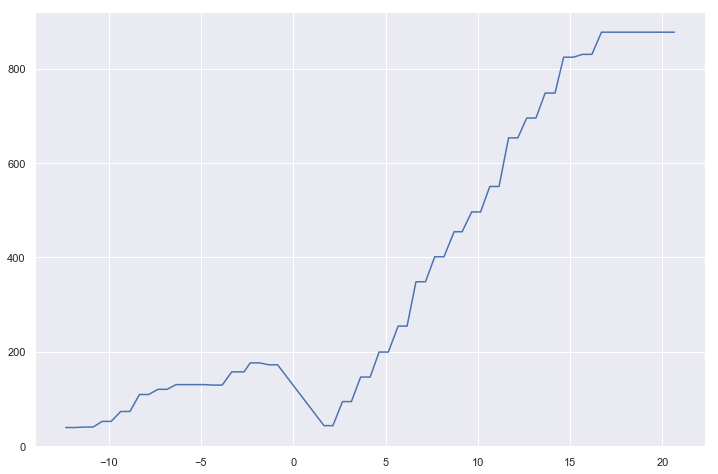

In [267]:
fig = plt.figure(figsize=(12,8))
# for cc in set(dataf[8]):
# #     plt.plot(f_t[cc], a_d[cc])
#     plt.plot([x/60 for x in f_t[cc]], a_d[cc])
plt.plot([x/60 for x in f_t[4]], a_d[4])
plt.show()

In [255]:
sns.set(style="ticks")
# # Load the example Titanic dataset
# titanic = sns.load_dataset("titanic")
# print(type(titanic))
# print(dataf.head())


In [229]:
qry3 = (" SELECT S.STOP_ID, S.STOP_NAME, COUNT(DISTINCT TRIP_ID)"
        " FROM GTFS.TRIP_UPDATES TU, GTFS.STOPS S"
        " WHERE TU.STOP_ID = S.STOP_ID"
        " AND UPPER(S.STOP_NAME) LIKE '%AMSTERDAM,%'"
        " GROUP BY S.STOP_ID"
        " ORDER BY S.STOP_NAME;")

df3 = exec_query(qry3)

Connected to DB ... 128
exec_query() ... 
 SELECT S.STOP_ID, S.STOP_NAME, COUNT(DISTINCT TRIP_ID) FROM GTFS.TRIP_UPDATES TU, GTFS.STOPS S WHERE TU.STOP_ID = S.STOP_ID AND UPPER(S.STOP_NAME) LIKE '%AMSTERDAM,%' GROUP BY S.STOP_ID ORDER BY S.STOP_NAME;
MySQL connection is closed


         0                                 1   2
0    15128  Amsterdam, 1e Con. Huygensstraat  29
1    15130  Amsterdam, 1e Con. Huygensstraat  35
2    96428       Amsterdam, A.J. Ernststraat  46
3  1401130       Amsterdam, A.J. Ernststraat  45
4    96469          Amsterdam, Amstelstation  85


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000165529681D0>]],
      dtype=object)

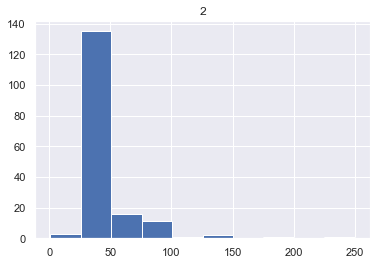

In [269]:
print(df3.head())
sns.set()

df3.hist()

In [270]:
qry4 = (" SELECT STOP_ID, TRIP_ID, MAX(ARRIVAL_DELAY), MIN(ARRIVAL_DELAY), AVG(ARRIVAL_DELAY), "
        " MAX(DEPARTURE_DELAY), MIN(DEPARTURE_DELAY), AVG(DEPARTURE_DELAY)"
        " FROM GTFS.TRIP_UPDATES"
        " GROUP BY STOP_ID, TRIP_ID;")
df4 = exec_query(qry4)

Connected to DB ... 128
exec_query() ... 
 SELECT STOP_ID, TRIP_ID, MAX(ARRIVAL_DELAY), MIN(ARRIVAL_DELAY), AVG(ARRIVAL_DELAY),  MAX(DEPARTURE_DELAY), MIN(DEPARTURE_DELAY), AVG(DEPARTURE_DELAY) FROM GTFS.TRIP_UPDATES GROUP BY STOP_ID, TRIP_ID;
MySQL connection is closed


In [ ]:
print(df4.head())
sns.set(style="whitegrid")
ax = sns.boxplot(x=df4[0], y=df4[1])

         0         1   2   3         4   5   6         7
0  1542109  84754596   0   0    0.0000   0   0    0.0000
1  1134317  84754596 -84 -84  -84.0000   6   6    6.0000
2  1133827  84754596  27  27   27.0000  27  27   27.0000
3  1377769  84754596 -11 -11  -11.0000 -11 -11  -11.0000
4  1133858  84754596 -10 -10  -10.0000  34  34   34.0000
